In [ ]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("imdb")
print(dataset)

Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 904291.73 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
from transformers import AutoTokenizer

In [4]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: be7e16b4-bf1c-40e6-9cfd-1eda1fc85e9c)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


In [5]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 50000/50000 [00:08<00:00, 5666.18 examples/s]


In [6]:
tokenizer("This movie was great!")

{'input_ids': [101, 2023, 3185, 2001, 2307, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [7]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

print(f"Total parameters: {model.num_parameters():,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 66,955,010


In [ ]:
import torch
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="binary")
    }


small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(500))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)


training_args = TrainingArguments(
    fp16=True,
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    dataloader_num_workers=4,
    gradient_checkpointing=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/z6/nlvy_ths6bjcg9v6vk1mtsj40000gn/T/ipykernel_46682/2400065331.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

/Users/akash/miniconda3/envs/ddods/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.310819,0.868000,0.870079
2,0.314400,0.302039,0.890000,0.890220
3,0.314400,0.331014,0.890000,0.891519


/Users/akash/miniconda3/envs/ddods/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/akash/miniconda3/envs/ddods/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=189, training_loss=0.22972287576665323, metrics={'train_runtime': 505.2481, 'train_samples_per_second': 5.938, 'train_steps_per_second': 0.374, 'total_flos': 397402195968000.0, 'train_loss': 0.22972287576665323, 'epoch': 3.0})

In [49]:
history = trainer.state.log_history

train_losses = [x['loss'] for x in history if 'loss' in x]
eval_losses = [x['eval_loss'] for x in history if 'eval_loss' in x]

print(train_losses)
print(eval_losses)

[]
[]


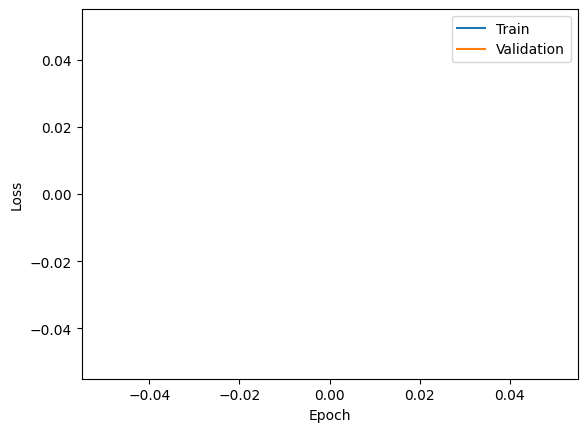

In [50]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot(eval_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
trainer.save_model("./results/best_model")

In [23]:
tokenizer.save_pretrained("./results/best_model")

('./results/best_model/tokenizer_config.json',
 './results/best_model/special_tokens_map.json',
 './results/best_model/vocab.txt',
 './results/best_model/added_tokens.json',
 './results/best_model/tokenizer.json')

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

small_test_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(100))

predictions = trainer.predict(small_test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)


print(classification_report(
    small_test_dataset["label"],
    preds,
    target_names=["NEGATIVE", "POSITIVE"]
))

/Users/akash/miniconda3/envs/ddods/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

    NEGATIVE       0.92      0.85      0.88        53
    POSITIVE       0.84      0.91      0.88        47

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



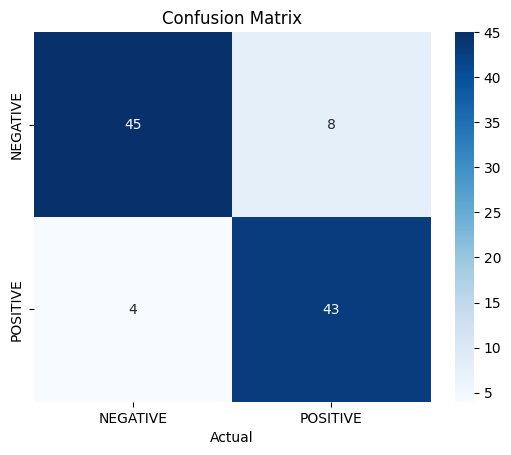

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(small_test_dataset["label"], preds)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["NEGATIVE", "POSITIVE"],
    yticklabels=["NEGATIVE", "POSITIVE"]
)
plt.xlabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch


def predict_sentiment(text, model, tokenizer):
    # tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )
    
    # Move inputs to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)
    
    return {
        "text": text,
        "sentiment": "POSITIVE" if predictions == 1 else "NEGATIVE",
        "confidence": probabilities[0][predictions].item()
    }


my_review = "This movie was absolutely fantastic! The active was superb and the storyline kept me engaged throughout."
result = predict_sentiment(my_review, model, tokenizer)
print(result)

{'text': 'This movie was absolutely fantastic! The active was superb and the storyline kept me engaged throughout.', 'sentiment': 'POSITIVE', 'confidence': 0.9664452075958252}
